In [1]:
from qpe import *

from numpy.random import permutation

from time import time
from scipy.stats import gaussian_kde

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rc('text', usetex=True)

In [2]:
def aux_info(dms, labels, n_layers, pars, n_copies=1, n_meas=0):

    n_inp = int(log2(len(dms[0])))
    n_tot = n_inp*n_copies
    d = 2**n_tot
    d_diff = 2**(n_tot - n_meas)
    
    if n_meas == 0:
        n_meas = n_tot
    
    pars_ans = pars[:-2**n_meas]
    pars_est = pars[-2**n_meas:]
    
    ansatz = hea_cry_rzrx(n_tot, n_layers, pars_ans)
    # CX_cascade = cx_cascade(n_tot)
    # ansatz = hea_cx_rzrx(n_tot, n_layers, CX_cascade, pars_ans)

    obs_u = ansatz.conj().T@kron_A_N(diag(pars_est), d_diff)@ansatz
    obs_u_sq = obs_u@obs_u
    
    # projs = [reduce(kron, [diag(line), eye(2**(n_tot - n_meas))]) for line in eye(2**n_meas)]
    # projs_u = [ansatz.conj().T@proj@ansatz for proj in projs]

    dms_cop = [reduce(kron, [dm]*n_copies) for dm in dms]
    
    expecs = []
    disps = []
    for dm in dms_cop:
        expec = trace(dm@obs_u).real
        disp = trace(dm@obs_u_sq).real - expec**2
        expecs.append(expec)
        disps.append(disp)
        
    
    return array(expecs), array(disps)

### Settings

In [3]:
n_inp = 2
n_test = 10000
mixed = True
marks = "neg"

dms_test, labels_test = gen_even_ent_data(n_test, n_inp=n_inp, mixed=mixed, marks=marks)
purities_test = [trace(dm@dm).real for dm in dms_test]

## Pass $T$

In [5]:
n_copies = 2
n_layers = 2
n_tot = n_inp*n_copies
n_meas = n_inp*n_copies

In [6]:
w_ls = 1e0
w_var = 1e-4
method = "BFGS"
options = {"maxiter": int(1e6)}#, "maxfun": int(1e10)}#
T_min, T_max, T_step = 100, 700, 100
n_train_list = arange(T_min, T_max + 1, T_step)

n_runs = 2

path = "/home/kardashin/Work/QPE/Results/Entanglement/Training_set_size/"
pref = "c=%d-m=%d-l=%d-w_ls=%.1f-w_var=%.4f-T=(%d,%d,%d)-%s" %(n_copies, n_meas, n_layers, w_ls, w_var, T_min, T_max, T_step, method)
path + pref

'/home/kardashin/Work/QPE/Results/Entanglement/Training_set_size/c=2-m=4-l=2-w_ls=1.0-w_var=0.0001-T=(100,400,100)-BFGS'

In [8]:
fvals_list = []
xf_list = []
nfev_list = []
time_list = []
error_test_list = []
dms_train_full_list = []
labels_train_full_list = []

for r in range(n_runs):
    print("r: %d" %r)

    dms_train_full, labels_train_full = gen_even_ent_data(n_train_list[-1], n_inp=n_inp, mixed=mixed, marks=marks)
    # shuffle
    perm = permutation(len(labels_train_full))
    dms_train_full = array(dms_train_full)[perm]
    labels_train_full = array(labels_train_full)[perm]
    dms_train_full_list.append(dms_train_full)
    labels_train_full_list.append(labels_train_full)

    file_name = path + pref + "-r=%d"%r
    np.save(file_name + "-labels_train", dms_train_full)
    np.save(file_name + "-dms_train", labels_train_full)
    
    x0 = array(concatenate([uniform(0, 2*pi, (3*n_layers + 2)*n_tot), uniform(0, 1, 2**n_meas)]))
    
    fvals_list_r = []
    xf_list_r = []
    nfev_list_r = []
    time_list_r = []
    error_test_list_r = []
    for n_train in n_train_list:
        print("\tn_train: %d" %n_train)
        
        dms_train = dms_train_full[:n_train]
        labels_train = labels_train_full[:n_train]

        file_name = path + pref + "-r=%d-Tr=%d"%(r, n_train)
        
        print("\t\tTraining")
        time_start = time()
        fvals, result = train(dms_train, labels_train, n_layers, 
                                  n_copies=n_copies, n_meas=n_meas, x0=x0,
                                  method=method, w_ls=w_ls, w_var=w_var, options=options,
                                  save_data=True, file_name=file_name)
        time_finish = time() - time_start
        print("\n\t\t\tFinished in", time_finish)
        print("\t\t\t", result.message)
        print("\t\t\tCost:", result.fun)
        
        x0 = result.x
        
        print("\t\tTesting")
    
        expecs_test, disps_test = aux_info(dms_test, labels_test, n_layers, result.x, n_copies=n_copies, n_meas=n_meas)
        error_test = np.sum((expecs_test - labels_test)**2)
        print("\t\t\tTesting error:", error_test)

        fvals_list_r.append(fvals)
        xf_list_r.append(result.x)
        nfev_list_r.append(result.nfev)
        time_list_r.append(time_finish)
        error_test_list_r.append(error_test)

        np.save(file_name + "-fvals", array(fvals_list_r, dtype=object))
        np.save(file_name + "-pars", array(xf_list_r))
        np.save(file_name + "-nfev", array(nfev_list_r))
        np.save(file_name + "-time", array(time_list_r))
        np.save(file_name + "-error", array(error_test_list_r))

    fvals_list.append(fvals_list_r)
    xf_list.append(xf_list_r)
    nfev_list.append(nfev_list_r)
    time_list.append(time_list_r)
    error_test_list.append(error_test_list_r)

    file_name = path + pref + "-r=%d"%r
    np.save(file_name + "-fvals", array(fvals_list_r, dtype=object))
    np.save(file_name + "-pars", array(xf_list_r))
    np.save(file_name + "-nfev", array(nfev_list_r))
    np.save(file_name + "-time", array(time_list_r))
    np.save(file_name + "-error", array(error_test_list_r))

r: 0
	n_train: 100
		Training
			Iteration: 184 | Cost: 0.55977521 | Time passed: 16 s
			Finished in 16.149211883544922
			 Optimization terminated successfully.
			Cost: 0.5597752087117462
		Testing
			Testing error: 330.57414075005346
	n_train: 200
		Training
			Iteration: 337 | Cost: 0.34381403 | Time passed: 47 s
			Finished in 47.03334069252014
			 Optimization terminated successfully.
			Cost: 0.3438140295299991
		Testing
			Testing error: 33.052606332001105
	n_train: 300
		Training
			Iteration: 135 | Cost: 0.54477856 | Time passed: 26 s
			Finished in 26.214076280593872
			 Optimization terminated successfully.
			Cost: 0.5447785628830611
		Testing
			Testing error: 26.774699973071982
	n_train: 400
		Training
			Iteration: 80 | Cost: 0.75279218 | Time passed: 20 s
			Finished in 20.90498924255371
			 Optimization terminated successfully.
			Cost: 0.7527921764409504
		Testing
			Testing error: 25.116074960875007
r: 1
	n_train: 100
		Training
			Iteration: 222 | Cost: 0.61214600

[ 16.25387422 -13.76788172  70.32868424]


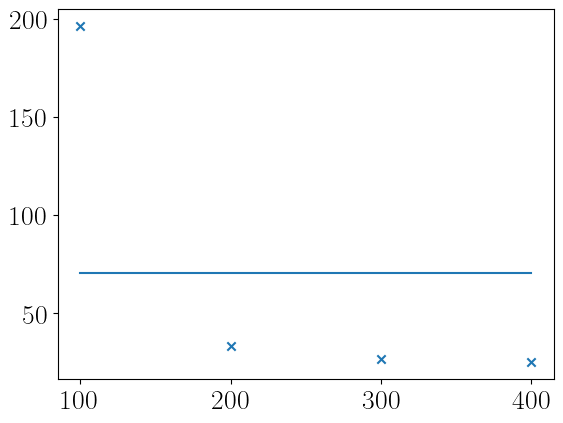

In [12]:
from scipy.optimize import curve_fit

# method = "lm"
# method = "trf"
method = "dogbox"

# def fit_func(x, a, b): return a*x**(-1/2) + b
# def fit_func(x, a, b): return (x**a)*b
def fit_func(x, a, b, c): return (x**b)*a + c

# popt, pcov = curve_fit(fit_func, n_train_list, np.mean(error_test_list, axis=0), method=method)#, bounds=bounds)
popt, pcov = curve_fit(fit_func, n_train_list, np.min(error_test_list, axis=0), method=method)#, bounds=bounds)

print(popt)
# plt.scatter(n_train_list, np.mean(error_test_list, axis=0))
plt.scatter(n_train_list, np.min(error_test_list, axis=0), marker="x")
plt.plot(n_train_list, fit_func(n_train_list, *popt))

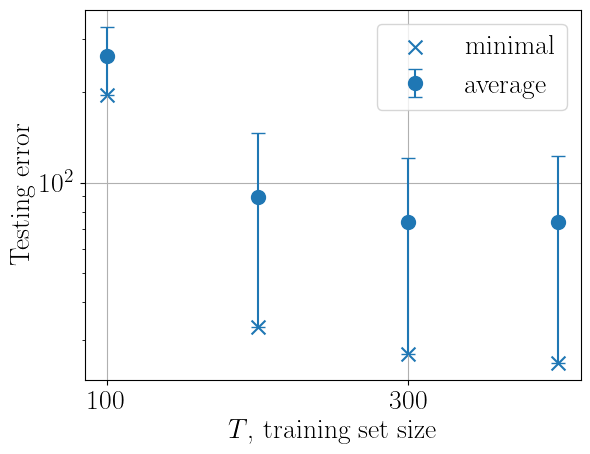

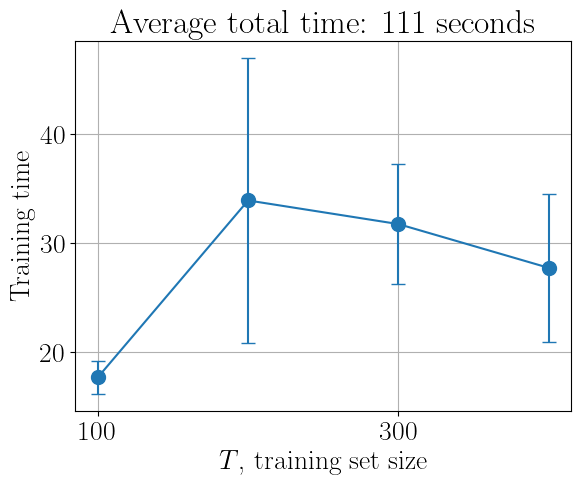

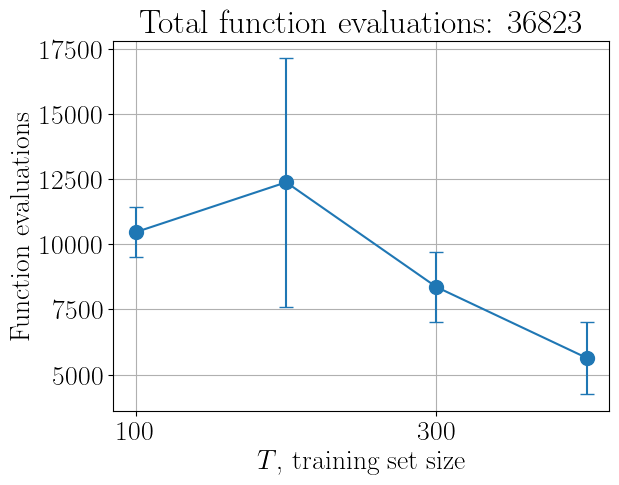

In [14]:
plt.errorbar(n_train_list, np.mean(error_test_list, axis=0), yerr=np.std(error_test_list, axis=0), linestyle="", marker="o", markersize=10, capsize=5, label="average")
plt.scatter(n_train_list, np.min(error_test_list, axis=0), marker="x", s=100, label="minimal")
# plt.plot(n_train_list, [1e6*n_train**(-4/3) for n_train in n_train_list], label="fit")
# plt.plot(n_train_list, fit_func(n_train_list, *popt), label=r"$%.3f\, T^{%.3f} + %.3f$" %tuple(popt))
plt.xticks(n_train_list[::2], n_train_list[::2])
plt.xlabel(r"$T$, training set size")
plt.ylabel(r"Testing error")
plt.yscale("log")
plt.grid()
plt.legend()
plt.show()

plt.errorbar(n_train_list, np.mean(time_list, axis=0), yerr=np.std(time_list, axis=0), marker="o", markersize=10, capsize=5)
plt.xticks(n_train_list[::2], n_train_list[::2])
plt.xlabel(r"$T$, training set size")
plt.ylabel(r"Training time")
plt.title(r"Average total time: %d seconds" %np.sum(np.mean(time_list, axis=0)))
# plt.yscale("log")
plt.grid()
plt.show()

plt.errorbar(n_train_list, np.mean(nfev_list, axis=0), yerr=np.std(nfev_list, axis=0), marker="o", markersize=10, capsize=5)
plt.xticks(n_train_list[::2], n_train_list[::2])
plt.xlabel(r"$T$, training set size")
plt.ylabel(r"Function evaluations")
plt.title(r"Total function evaluations: %d" %np.sum(np.mean(nfev_list, axis=0)))
# plt.yscale("log")
plt.grid()
plt.show()

## Pass copies, $H_2 \rightarrow H_2 \otimes H_2$ 

In [4]:
def duplicate_ansatz(pars, n_tot, n_meas, n_layers):
    """Given HEA ansatz parameters pars which produce an observable H, returns new ansatz parameters x0 which produce H⊗H."""
    x0 = []
    it = iter(pars)
    
    # zeroth layer
    x0_l = []
    for q in range(n_tot):
        x0_l.append(next(it)) # Rx
        x0_l.append(next(it)) # Rz
    x0_l = x0_l + x0_l # copy to the rest qubits
    x0 = x0 + x0_l # add layer
    
    # the rest layers
    for l in range(n_layers):
        x0_l_t = [] # CRy rotations
        for q in range(n_tot - 1):
            x0_l_t.append(next(it)) # CRy(q, q + 1)
        # if n_tot > 2:
        #     x0_l_t.append(next(it))  # CRy(0, n - 1)
        x0_l_t = x0_l_t + [0] + x0_l_t # set the CRy-gate between the parts to the identity, copy to the rest qubits
        x0_l_s = [] # single-qubit rotations
        for q in range(n_tot):
            x0_l_s.append(next(it)) # Rx
            x0_l_s.append(next(it)) # Rz
        x0_l_s = x0_l_s + x0_l_s # copy to the rest qubits
        x0 = x0 + x0_l_t + x0_l_s # add layer
        
    pars_est = pars[-2**n_meas:] # eigenvalues x_i
    x0_est = []
    for i in range(2**n_meas):
        for j in range(2**n_meas):
            x0_est.append(pars_est[i]*pars_est[j])
    x0 = x0 + x0_est
    
    return x0

In [5]:
n_inp = 2
n_copies = 2
n_tot = n_inp*n_copies
n_meas = n_inp*n_copies
d_diff = 2**(n_tot - n_meas)
n_layers = 3

n_pars_est = 2**n_meas
n_pars_ans = 2*n_tot + (3*n_tot - 1)*n_layers # n_tot*(2 + 3*n_layers)

pars_ans = arange(n_pars_ans) # uniform(0, 2*pi, n_pars_ans)
pars_est = arange(n_pars_ans, n_pars_ans + n_pars_est) # uniform(-1, 1, n_pars_est)
pars = concatenate([pars_ans, pars_est])

U = hea_cry_rzrx(n_tot, n_layers, pars_ans)
H_u = U.conj().T@kron_A_N(diag(pars_est), d_diff)@U



pars_dup = duplicate_ansatz(pars, n_tot, n_meas, n_layers)
n_pars_est_dup = 2**(2*n_meas)
n_pars_ans_dup = 2*2*n_tot + (2*3*n_tot - 1)*n_layers # (2*n_tot)*(2 + 3*n_layers)

U_dup = hea_cry_rzrx(2*n_tot, n_layers, pars_dup[:-n_pars_est_dup])
H_dup = U_dup.conj().T@kron_A_N(diag(pars_dup[-n_pars_est_dup:]), d_diff)@U_dup

print(norm(kron(U, U) - U_dup))
print(norm(kron(H_u, H_u) - H_dup))

1.5647685081176247e-14
5.731219629874708e-11
